In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../data/raw/SeoulBikeData.csv')

In [5]:
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [7]:
# Determine start and end date for each season in Seasons
seasons = df['Seasons'].unique()

season_dates = {}

for season in seasons:
    season_df = df[df['Seasons'] == season]
    start_date = pd.to_datetime(season_df['Date'], dayfirst=True).min()
    end_date = pd.to_datetime(season_df['Date'], dayfirst=True).max()
    season_dates[season] = (start_date, end_date)

season_dates

{'Winter': (Timestamp('2017-12-01 00:00:00'),
  Timestamp('2018-02-28 00:00:00')),
 'Spring': (Timestamp('2018-03-01 00:00:00'),
  Timestamp('2018-05-31 00:00:00')),
 'Summer': (Timestamp('2018-06-01 00:00:00'),
  Timestamp('2018-08-31 00:00:00')),
 'Autumn': (Timestamp('2018-09-01 00:00:00'),
  Timestamp('2018-11-30 00:00:00'))}

In [8]:
# There are not enough data for doing comparisons season-wise. I held out the tail of the dataset for monitoring
# even if I can expect data drifting due to seasonal effects

curr_data = df.loc[df['Seasons']=='Autumn'].reset_index(drop=True)
ref_data = df.loc[df['Seasons']!='Autumn']

In [9]:
curr_data.shape, ref_data.shape

((2184, 14), (6576, 14))

In [10]:
ref_data.to_csv('../data/interim/ref_data.csv', index=False)
curr_data.to_csv('../data/interim/curr_data.csv', index=False)

## Preprocessing

In [12]:
# begin statistical analysis and preprocessing for modeling on ref_data 
# curr_data will be used for monitoring and it is held out from now on to avoid leakage
ref_data.shape

(6576, 14)

In [13]:
# Reformat column titles also removing unit measurements
#ref_data.columns = ref_data.columns.str.lower().str.replace(r"\s*\(.*\)\s*", "").str.replace(' ', '_')
ref_data.columns = ref_data.columns.str.lower().str.replace("\s*\(.*\)\s*", "", regex=True).str.replace(' ', '_')

In [14]:
#from date column (string format) create new column with progressive day numbers (int type)
ref_data['day_number'] = pd.to_datetime(ref_data['date'], dayfirst=True)
ref_data['day_number'] = (ref_data['day_number'] - ref_data['day_number'].min()).dt.days + 1

ref_data['day_number'] = ref_data['day_number'].map({value: index+1 for index, value in enumerate(ref_data['day_number'].unique())})

In [15]:
#add a column with day of the week
ref_data['weekday'] = pd.to_datetime(ref_data['date'], dayfirst=True).dt.strftime('%A')

In [16]:
ref_data.drop(columns='date', inplace=True)

In [17]:
#check the hypothesis: zero-bike rent equals no_functioning day.

no_functioning = ref_data.loc[ref_data['functioning_day']=='No']
zero_bike = ref_data.loc[ref_data['rented_bike_count']==0]

zero_bike.equals(no_functioning)

True

<Axes: xlabel='hour', ylabel='rented_bike_count'>

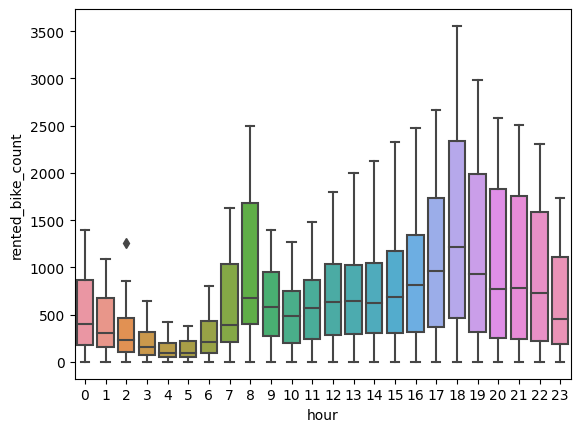

In [18]:
# Plot boxplot of rented_bike_count across hour column
sns.boxplot(x='hour', y='rented_bike_count', data=ref_data)

<Axes: xlabel='weekday', ylabel='rented_bike_count'>

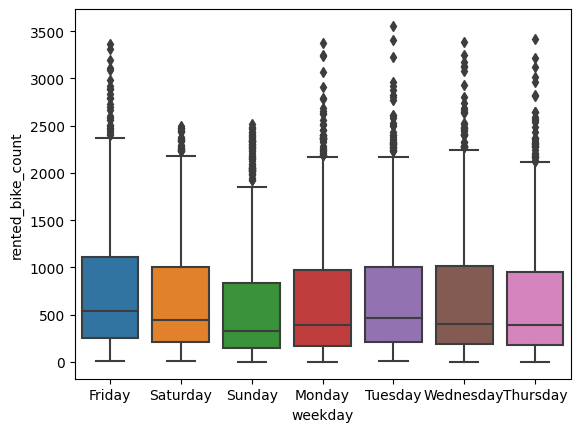

In [19]:
# Plot boxplot of rented_bike_count across weekday column
sns.boxplot(x='weekday', y='rented_bike_count', data=ref_data)

<Axes: >

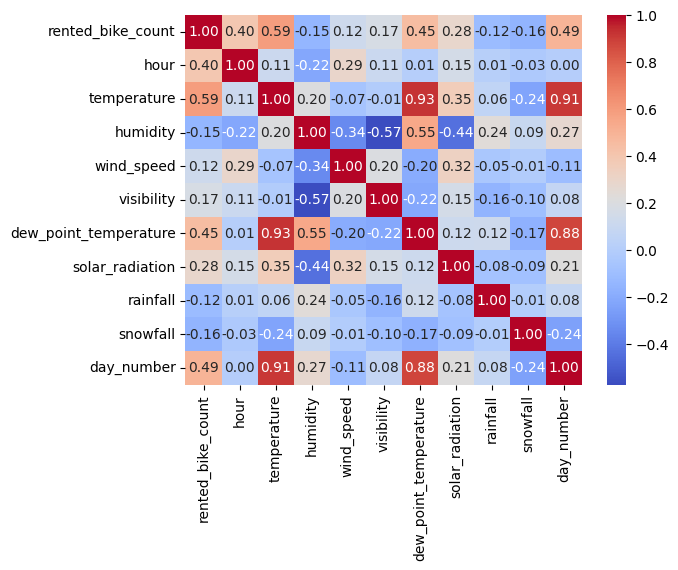

In [20]:
# Calculate the correlation matrix (only numeric features involved)
correlation_matrix = ref_data.corr(numeric_only=True)

# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")

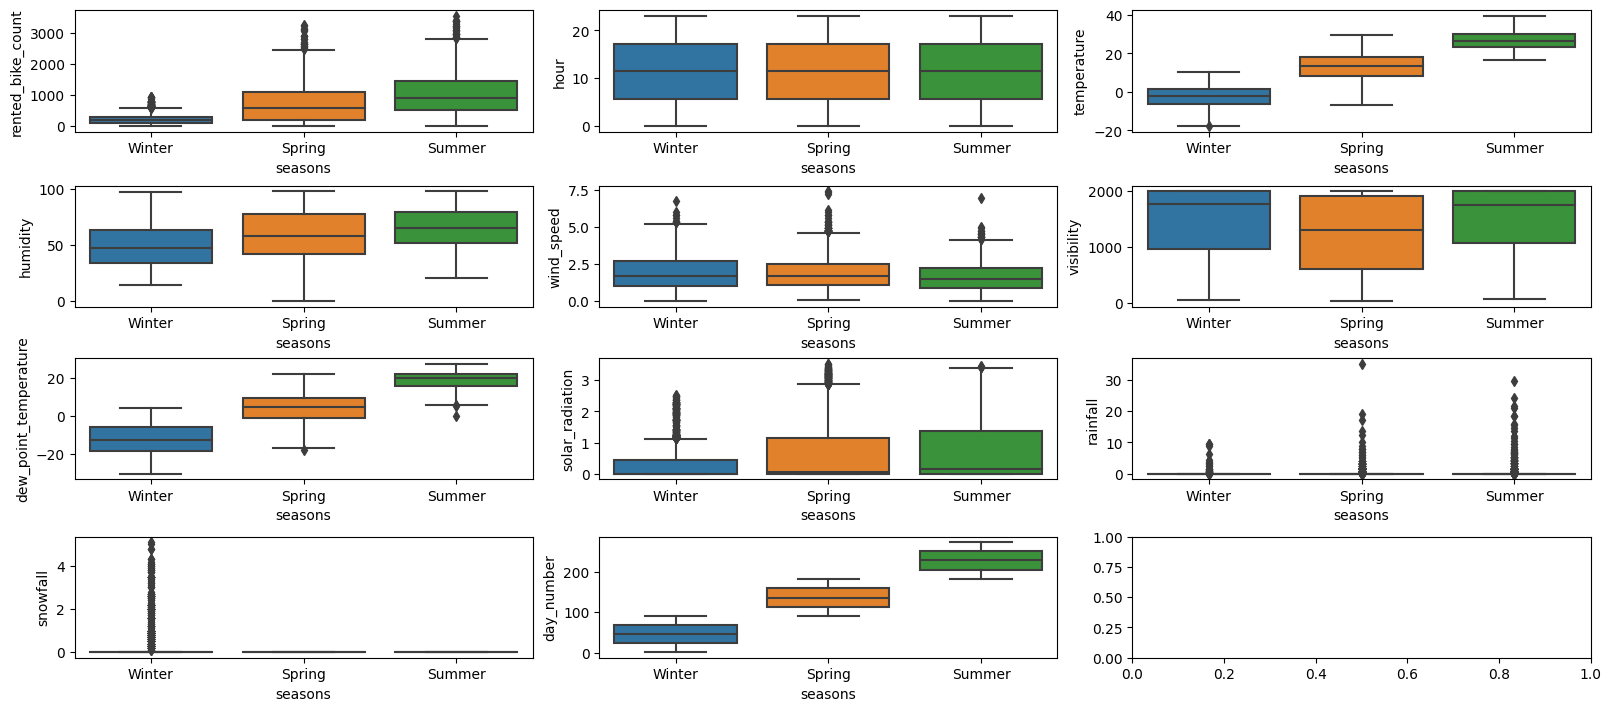

In [21]:
# boxplot across seasons

columns = list(ref_data.select_dtypes(include=['int64', 'float64']).columns)
gridx, gridy = 0, 0
fig, ax = plt.subplots(4 , 3, figsize=(16, 7), constrained_layout=True)
for column in columns:
    sns.boxplot(x=ref_data.seasons, y=ref_data[column], ax=ax[gridx, gridy])
    gridy += 1
    if gridy == 3:
        gridy = 0
        gridx += 1
    if gridx == 4:
        gridx = 0
plt.show()

Rented Bike Count: mean 666.41, median 419.0, std 638.45
...........................................................................


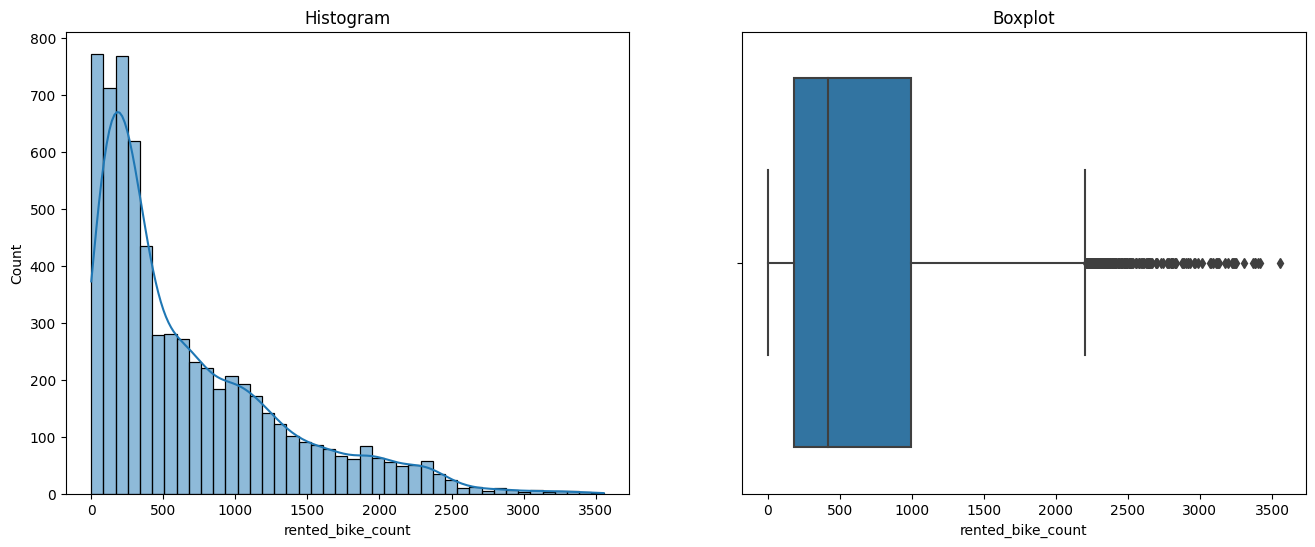

In [22]:
#distribution of the target variable
print('Rented Bike Count: mean {:.2f}, median {}, std {:.2f}'.format(ref_data.rented_bike_count.mean(),
                                                                     ref_data.rented_bike_count.median(),
                                                                     ref_data.rented_bike_count.std()))
print('.'*75)
figure, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(ax=ax[0], data=ref_data, x='rented_bike_count', kde=True)
ax[0].set_title('Histogram')
sns.boxplot(ax=ax[1], data=ref_data, x='rented_bike_count')
ax[1].set_title('Boxplot')
plt.show()

### Feature Importance analysis

In [23]:
y = ref_data.rented_bike_count.values
X = ref_data.drop(columns='rented_bike_count',axis=1)

In [24]:
#data split for feature importance analysis
df_train, df_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

In [25]:
X.columns

Index(['hour', 'temperature', 'humidity', 'wind_speed', 'visibility',
       'dew_point_temperature', 'solar_radiation', 'rainfall', 'snowfall',
       'seasons', 'holiday', 'functioning_day', 'day_number', 'weekday'],
      dtype='object')

In [26]:
numerical = list(df_train.select_dtypes(include=['int64', 'float64']).columns)
categorical = list(df_train.select_dtypes(include='object').columns)

categorical_preprocessor = OneHotEncoder()
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical),
        ("standard_scaler", numerical_preprocessor, numerical),
    ]
)

In [27]:
model = make_pipeline(preprocessor, Ridge(alpha=3))

In [28]:
_ = model.fit(df_train, y_train)

In [29]:
feature_names = model[0].get_feature_names_out()
substrings = [name.split('__')[1] for name in feature_names]

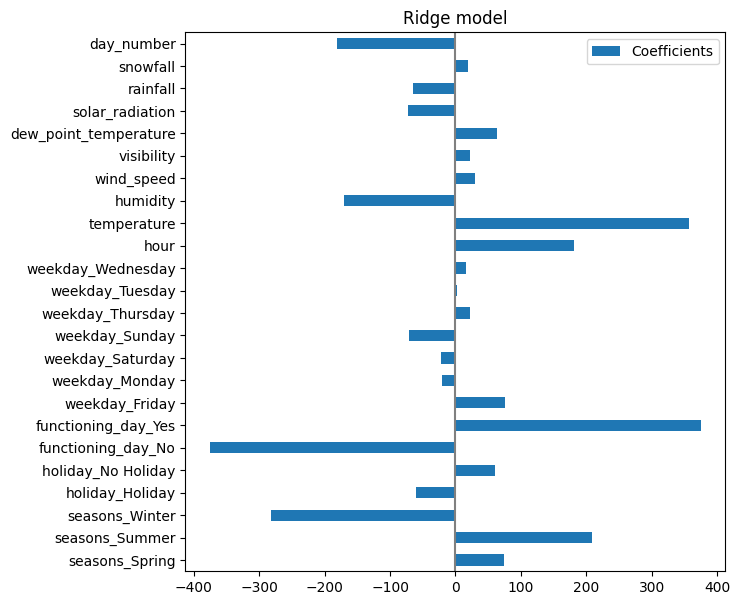

In [30]:
coefs = pd.DataFrame(
    model[1].coef_, columns=["Coefficients"], index=substrings
)

coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [31]:
model2 = make_pipeline(preprocessor, RandomForestRegressor(max_depth=10))

model2.fit(df_train, y_train)

importances = model2[1].feature_importances_

In [32]:
feature_names = model2[0].get_feature_names_out()
substrings = [name.split('__')[1] for name in feature_names]

indices = np.argsort(importances)
reordered_substrings = [substrings[i] for i in indices]

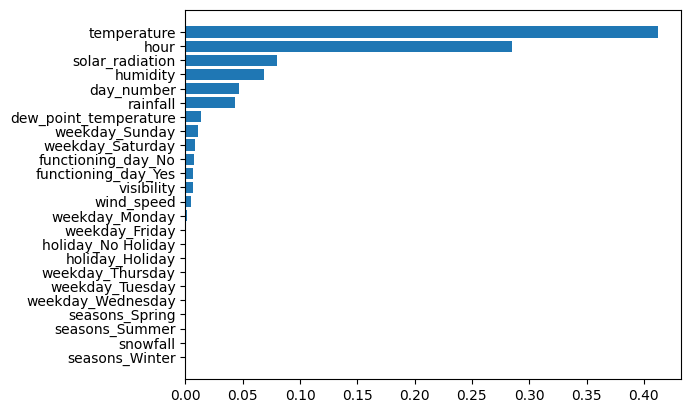

In [33]:
fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(reordered_substrings)

### Baseline model

In [34]:
# feature selection by trial and error
#X_sel = X[['temperature', 'hour', 'humidity', 'solar_radiation', 'seasons']]
#X_sel = X[['temperature', 'hour', 'day_number', 'seasons', 'holiday', 'weekday']]
#X_sel = X[['temperature', 'humidity', 'hour', 'day_number', 'seasons', 'holiday', 'weekday']]
#X_sel = X[['temperature', 'hour', 'humidity', 'solar_radiation', 'rainfall', 'snowfall',  'seasons', 'holiday', 'weekday']]
#X_sel = X[['temperature', 'hour', 'humidity', 'day_number', 'solar_radiation', 'rainfall', 'seasons', 'holiday', 'weekday']]

#X_sel=X[['hour','temperature','humidity','wind_speed','visibility','dew_point_temperature','solar_radiation','rainfall','snowfall','day_number','seasons','holiday','weekday']]

X_sel = X[['temperature', 'humidity', 'hour', 'day_number', 'rainfall', 'seasons', 'weekday']]

In [35]:
numerical = list(X_sel.select_dtypes(include=['int64', 'float64']).columns)
categorical = list(X_sel.select_dtypes(include='object').columns)

In [36]:
df2_train, df2_val, y_train, y_val = train_test_split(
        X_sel, y, random_state=42, stratify=X['seasons']
)

In [37]:
dv = DictVectorizer(sparse=False)

train_dicts = df2_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df2_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

441.7501019801491

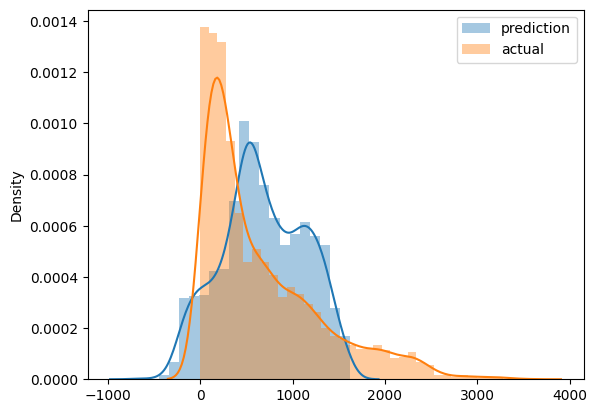

In [39]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()